In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import matplotlib
from bsmcalls import individuals
import attila_utils
%matplotlib inline

In [2]:
calls = individuals.get_data(merge=True, cleancalls=False)
calls.columns

Index(['REF', 'ALT', 'QUAL', 'FILTER/PASS', 'FILTER/HC', 'FILTER/EXT', 'AC',
       'AF', 'AN', 'BaseQRankSum', 'DP', 'DS', 'END', 'ExcessHet', 'FS',
       'InbreedingCoeff', 'MLEAC', 'MLEAF', 'MQ', 'MQRankSum',
       'NEGATIVE_TRAIN_SITE', 'POSITIVE_TRAIN_SITE', 'QD', 'RAW_MQandDP',
       'ReadPosRankSum', 'SOR', 'VQSLOD', 'culprit', 'ChromatinState_DLPFC',
       'szdbCNVcount', 'GWASpval', 'Institution', 'Reported Gender',
       'Ethnicity', 'ageOfDeath', 'Brain Weight (in grams)', 'PMI (in hours)',
       'Dx', 'Year of Autopsy', 'Benzodiazepines', 'Anticonvulsants',
       'AntipsychTyp', 'AntipsychAtyp', 'Antidepress', 'Lithium', 'Alcohol',
       'Illicitsub', 'causeOfDeath', 'EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5'],
      dtype='object')

The code below performs the following operations:
1. drop variant-level features
1. keep only NeuN_pl samples
1. remove duplicate rows

In [3]:
subjects = calls.drop(calls.columns[:31], axis=1).xs('NeuN_pl', axis=0, level='Tissue').groupby('Individual ID').first() # remove duplicate rows
subjects

,Institution,Reported Gender,Ethnicity,ageOfDeath,Brain Weight (in grams),PMI (in hours),Dx,Year of Autopsy,Benzodiazepines,Anticonvulsants,...,Antidepress,Lithium,Alcohol,Illicitsub,causeOfDeath,EV.1,EV.2,EV.3,EV.4,EV.5
Individual ID,,,,,,,,,,,,,,,,,,,,,
CMC_MSSM_027,MSSM,Male,Caucasian,66.0,1239.0,12.1,SCZ,1994.0,0,0,...,0,0,1,0,1,0.019061,-0.043151,0.005808,0.131348,-0.019458
CMC_MSSM_055,MSSM,Male,Caucasian,66.0,1370.0,23.9,Control,2005.0,0,0,...,0,0,0,0,1,0.020298,0.018617,-0.001543,-0.010232,0.002140
CMC_MSSM_056,MSSM,Female,Caucasian,67.0,1222.0,16.5,Control,2005.0,0,0,...,0,0,0,0,1,0.020853,0.030543,-0.006878,-0.011283,0.009727
CMC_MSSM_069,MSSM,Female,Hispanic,63.0,1214.0,20.2,Control,2004.0,0,0,...,1,0,0,0,1,-0.036995,-0.006866,-0.128398,0.015441,0.062868
CMC_MSSM_097,MSSM,Male,Caucasian,73.0,1036.0,50.6,SCZ,1992.0,0,0,...,0,0,0,0,1,0.020930,0.033332,0.005796,-0.006970,0.003070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC_PITT_098,Pitt,Male,Caucasian,56.0,1285.0,14.5,Control,1997.0,0,0,...,0,0,0,0,1,0.021925,0.017359,0.001280,0.002445,0.003736
CMC_PITT_101,Pitt,Male,Caucasian,42.0,1670.0,26.1,Control,1997.0,0,0,...,0,0,0,0,1,0.020204,-0.004967,-0.001258,0.041604,-0.004473
CMC_PITT_113,Pitt,Male,Caucasian,48.0,1575.0,16.6,Control,2000.0,0,0,...,0,0,0,0,1,0.020509,0.025007,-0.001910,-0.031377,0.030459


In [4]:
fpath = '../../results/2020-04-22-upload-to-ndar-from-s3/samples-from-Chaggai.csv'
samples_genewiz = pd.read_csv(fpath)
samples_genewiz = samples_genewiz.rename(dict(zip(samples_genewiz.index, ['CMC_' + x for x in samples_genewiz.CMC_simple_id])), axis=0)
samples_genewiz['Sequencing'] = 'GENEWIZ'
samples_genewiz = samples_genewiz.rename_axis('Individual ID', axis=0)
samples_genewiz

,CMC_simple_id,Dissection,PFC #,Dx,GENEWIZ_serialn,Index,Sequencing
Individual ID,,,,,,,
CMC_PITT_117,PITT_117,PITT,904,SCZ,1,A2,GENEWIZ
CMC_MSSM_364,MSSM_364,MSSM,1141,SCZ,2,A3,GENEWIZ
CMC_MSSM_363,MSSM_363,MSSM,1144,SCZ,3,A4,GENEWIZ
CMC_MSSM_308,MSSM_308,MSSM,1153,SCZ,5,A5,GENEWIZ
CMC_MSSM_339,MSSM_339,MSSM,1155,SCZ,6,A6,GENEWIZ
...,...,...,...,...,...,...,...
CMC_MSSM_379,MSSM_379,MSSM,1238,SCZ,D-MSSM-1238,D4,GENEWIZ
CMC_MSSM_340,MSSM_340,MSSM,1247,SCZ,E-MSSM-1247,E5,GENEWIZ
CMC_MSSM_362,MSSM_362,MSSM,1346,SCZ,F-MSSM-1346,F6,GENEWIZ


In [5]:
subjects = pd.merge(left=subjects, right=samples_genewiz[['Sequencing']], how='left', on='Individual ID')
subjects['Sequencing'] = subjects['Sequencing'].fillna('other')
subjects['Sequencing'] = pd.Categorical(subjects['Sequencing'], ordered=True)
subjects['Simple ID'] = [re.sub('CMC_([MP])..._([0-9]{3})$', '\\1\\2', s) for s in subjects.index]
subjects.to_csv('../../results/2022-04-06-sample-properties/subjects-sequencing-ancestry.csv')
subjects

,Institution,Reported Gender,Ethnicity,ageOfDeath,Brain Weight (in grams),PMI (in hours),Dx,Year of Autopsy,Benzodiazepines,Anticonvulsants,...,Alcohol,Illicitsub,causeOfDeath,EV.1,EV.2,EV.3,EV.4,EV.5,Sequencing,Simple ID
Individual ID,,,,,,,,,,,,,,,,,,,,,
CMC_MSSM_027,MSSM,Male,Caucasian,66.0,1239.0,12.1,SCZ,1994.0,0,0,...,1,0,1,0.019061,-0.043151,0.005808,0.131348,-0.019458,GENEWIZ,M027
CMC_MSSM_055,MSSM,Male,Caucasian,66.0,1370.0,23.9,Control,2005.0,0,0,...,0,0,1,0.020298,0.018617,-0.001543,-0.010232,0.002140,GENEWIZ,M055
CMC_MSSM_056,MSSM,Female,Caucasian,67.0,1222.0,16.5,Control,2005.0,0,0,...,0,0,1,0.020853,0.030543,-0.006878,-0.011283,0.009727,other,M056
CMC_MSSM_069,MSSM,Female,Hispanic,63.0,1214.0,20.2,Control,2004.0,0,0,...,0,0,1,-0.036995,-0.006866,-0.128398,0.015441,0.062868,GENEWIZ,M069
CMC_MSSM_097,MSSM,Male,Caucasian,73.0,1036.0,50.6,SCZ,1992.0,0,0,...,0,0,1,0.020930,0.033332,0.005796,-0.006970,0.003070,GENEWIZ,M097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC_PITT_098,Pitt,Male,Caucasian,56.0,1285.0,14.5,Control,1997.0,0,0,...,0,0,1,0.021925,0.017359,0.001280,0.002445,0.003736,GENEWIZ,P098
CMC_PITT_101,Pitt,Male,Caucasian,42.0,1670.0,26.1,Control,1997.0,0,0,...,0,0,1,0.020204,-0.004967,-0.001258,0.041604,-0.004473,other,P101
CMC_PITT_113,Pitt,Male,Caucasian,48.0,1575.0,16.6,Control,2000.0,0,0,...,0,0,1,0.020509,0.025007,-0.001910,-0.031377,0.030459,GENEWIZ,P113


['named-figure/ancestry-all-EVs-Dx.png',
 'named-figure/ancestry-all-EVs-Dx.pdf']

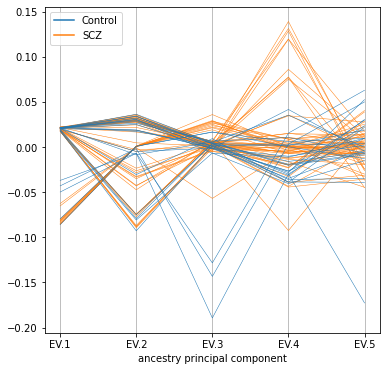

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
def plot_EVi(ax, Dx='Control', color='C0'):
    EVcols = ['EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5']
    subjects.loc[subjects.Dx == Dx, EVcols].transpose().plot(ax=ax, color=color, legend=None, linewidth=0.5)

plot_EVi(ax, Dx='SCZ', color='C1')
plot_EVi(ax, Dx='Control', color='C0')
ax.set_xticks(range(5))
ax.grid(axis='x')

def legend_Dx(ax, loc='upper right'):
    ax.legend([matplotlib.lines.Line2D(color='C0', xdata=[0, 1], ydata=[0, 0]), matplotlib.lines.Line2D(color='C1', xdata=[0, 1], ydata=[1, 1])], ['Control', 'SCZ'], loc=loc)

ax.set_xlabel('ancestry principal component')
legend_Dx(ax, loc='upper left')
attila_utils.savefig(fig, 'ancestry-all-EVs-Dx')

['named-figure/ancestry-all-EVs-Dx-ethnicity.png',
 'named-figure/ancestry-all-EVs-Dx-ethnicity.pdf']

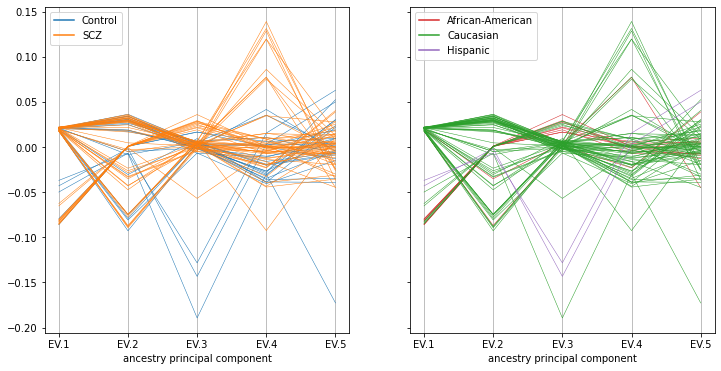

In [7]:
def plot_EVi_Dx(ax, Dx='Control', color='C0'):
    EVcols = ['EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5']
    subjects.loc[subjects.Dx == Dx, EVcols].transpose().plot(ax=ax, color=color, legend=None, linewidth=0.5)

def plot_EVi_ethnicity(ax, Ethnicity='African-American', color='C3'):
    EVcols = ['EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5']
    subjects.loc[subjects.Ethnicity == Ethnicity, EVcols].transpose().plot(ax=ax, color=color, legend=None, linewidth=0.5)

Dxs = ['Control', 'SCZ']
colors_Dx = ['C0', 'C1']
ethnicities = ['African-American', 'Caucasian', 'Hispanic']
colors = ['C3', 'C2', 'C4']

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for e, c in zip(Dxs, colors_Dx):
    plot_EVi_Dx(ax[0], Dx=e, color=c)
ax[0].set_xticks(range(5))
ax[0].grid(axis='x')
legend_Dx(ax[0], loc='upper left')

for e, c in zip(ethnicities, colors):
    plot_EVi_ethnicity(ax[1], Ethnicity=e, color=c)
ax[1].set_xticks(range(5))
ax[1].grid(axis='x')

def legend_ethnicity(ax, loc='upper right'):
    ax.legend([matplotlib.lines.Line2D(color=c, xdata=[0, 1], ydata=[y, y]) for c, y in zip(colors, range(3))], ethnicities, loc=loc)

ax[0].set_xlabel('ancestry principal component')
ax[1].set_xlabel('ancestry principal component')
legend_ethnicity(ax[1], loc='upper left')
attila_utils.savefig(fig, 'ancestry-all-EVs-Dx-ethnicity')

['named-figure/ancestry-EV3-EV4-Dx-ethnicity.png',
 'named-figure/ancestry-EV3-EV4-Dx-ethnicity.pdf']

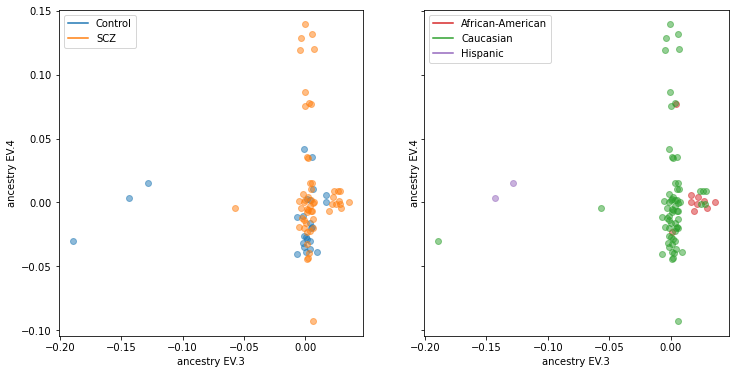

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
def scatter_EVi_Dx(ax, x='EV.3', y='EV.4', Dx='Control', color='C0'):
    ax.scatter(x=x, y=y, data=subjects.loc[subjects.Dx == Dx], alpha=0.5, color=color)

def scatter_EVi_ethnicity(ax, x='EV.3', y='EV.4', Ethnicity='African-American', color='C3'):
    ax.scatter(x=x, y=y, data=subjects.loc[subjects.Ethnicity == Ethnicity], alpha=0.5, color=color)

for e, c in zip(Dxs, colors_Dx):
    scatter_EVi_Dx(ax[0], x='EV.3', y='EV.4', Dx=e, color=c)
for e, c in zip(ethnicities, colors):
    scatter_EVi_ethnicity(ax[1], x='EV.3', y='EV.4', Ethnicity=e, color=c)

ax[0].set_xlabel('ancestry EV.3')
ax[0].set_ylabel('ancestry EV.4')
ax[1].set_xlabel('ancestry EV.3')
ax[1].set_ylabel('ancestry EV.4')
legend_Dx(ax[0], loc='upper left')
legend_ethnicity(ax[1], loc='upper left')
attila_utils.savefig(fig, 'ancestry-EV3-EV4-Dx-ethnicity')

['named-figure/ancestry-EV3-EV4-Dx-indivIDs.png',
 'named-figure/ancestry-EV3-EV4-Dx-indivIDs.pdf']

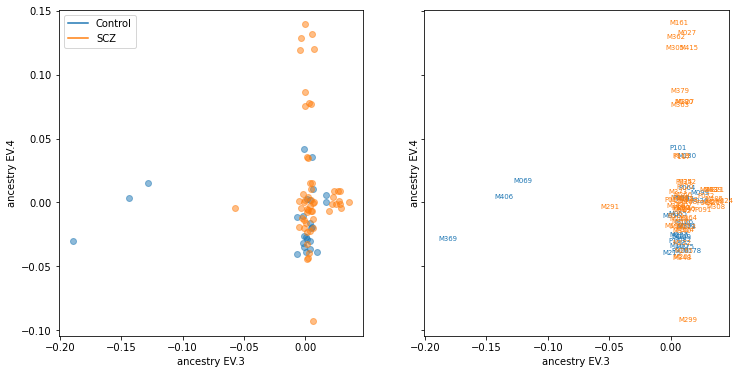

In [9]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
for e, c in zip(Dxs, colors_Dx):
    scatter_EVi_Dx(ax[0], x='EV.3', y='EV.4', Dx=e, color=c)

subjects1 = subjects.dropna(subset=['EV.3', 'EV.4'])
def scatter_EVi_indivIDs(ax, subjects1, x='EV.3', y='EV.4', Dx='Control', color='C0'):
    subj = subjects1.loc[subjects1.Dx == Dx]
    for fullid, simpleid in zip(subj.index, subj['Simple ID']):
        ax.text(x=subj.loc[fullid, 'EV.3'], y=subj.loc[fullid, 'EV.4'], s=simpleid, fontsize='x-small', color=color)

scatter_EVi_indivIDs(ax[1], subjects1, x='EV.3', y='EV.4', Dx='Control', color='C0')
scatter_EVi_indivIDs(ax[1], subjects1, x='EV.3', y='EV.4', Dx='SCZ', color='C1')
xlims = ax[0].get_xlim()
ylims = ax[0].get_ylim()
ax[1].set_xlim(*xlims)
ax[1].set_ylim(*ylims)
ax[0].set_xlabel('ancestry EV.3')
ax[0].set_ylabel('ancestry EV.4')
ax[1].set_xlabel('ancestry EV.3')
ax[1].set_ylabel('ancestry EV.4')

legend_Dx(ax[0], loc='upper left')
attila_utils.savefig(fig, 'ancestry-EV3-EV4-Dx-indivIDs')

['named-figure/ancestry-EV3-EV4-indivIDs.png',
 'named-figure/ancestry-EV3-EV4-indivIDs.pdf']

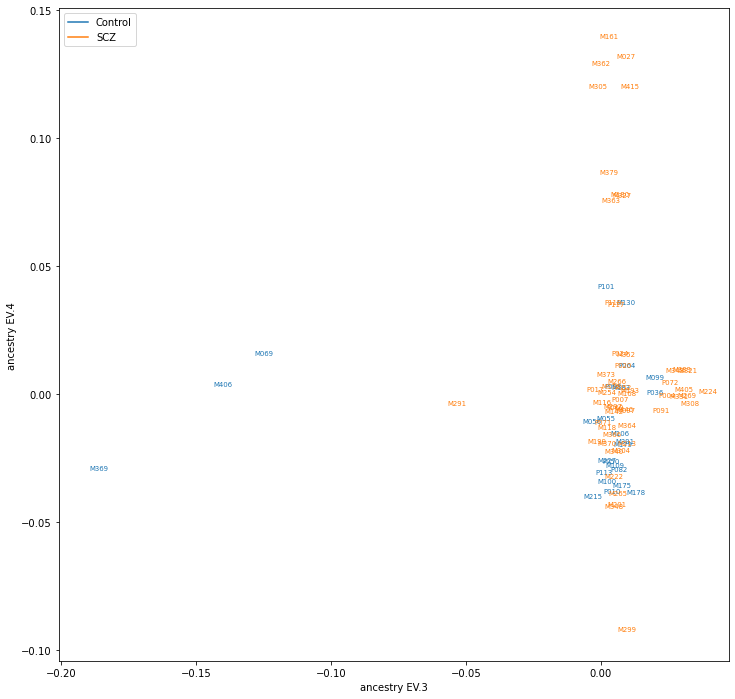

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

scatter_EVi_indivIDs(ax, subjects1, x='EV.3', y='EV.4', Dx='Control', color='C0')
scatter_EVi_indivIDs(ax, subjects1, x='EV.3', y='EV.4', Dx='SCZ', color='C1')
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_xlabel('ancestry EV.3')
ax.set_ylabel('ancestry EV.4')
legend_Dx(ax, loc='upper left')
attila_utils.savefig(fig, 'ancestry-EV3-EV4-indivIDs')

Define outliers on the left, top and bottom, respectively:

In [11]:
outliers_simpleID = ['M369', 'M406', 'M069', 'M291', \
                     'M161', 'M027', 'M362', 'M305', 'M415', 'M379', 'M180', 'M327', 'M363', \
                     'M299']
outliers = subjects.loc[subjects['Simple ID'].isin(outliers_simpleID), ['Simple ID', 'Dx']]
outliers.to_csv('../../results/2022-04-06-sample-properties/outliers-based-on-ancestry.csv')
outliers

,Simple ID,Dx
Individual ID,,
CMC_MSSM_027,M027,SCZ
CMC_MSSM_069,M069,Control
CMC_MSSM_161,M161,SCZ
CMC_MSSM_180,M180,SCZ
CMC_MSSM_291,M291,SCZ
CMC_MSSM_299,M299,SCZ
CMC_MSSM_305,M305,SCZ
CMC_MSSM_327,M327,SCZ
CMC_MSSM_362,M362,SCZ


Dx,Control,SCZ
Sequencing,,
GENEWIZ,12,52
other,13,9


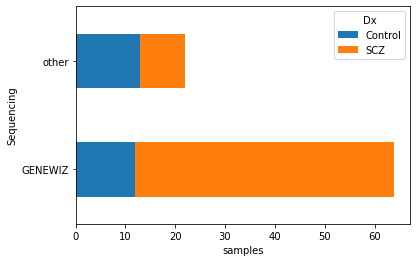

In [12]:
def crosstab_plot(othervar='Sequencing'):
    fig, ax = plt.subplots()
    ct = pd.crosstab(subjects[othervar], subjects.Dx)#.transpose()
    ct.plot.barh(stacked=True, ax=ax)
    ax.set_xlabel('samples')
    return((ct, fig, ax))

ct, fig, ax = crosstab_plot(othervar='Sequencing')
attila_utils.savefig(fig, 'Dx-distro-sequencing-batches')
ct

Dx,Control,SCZ
Institution,,
MSSM,17,49
Pitt,8,12


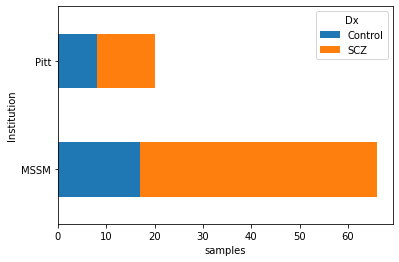

In [13]:
ct, fig, ax = crosstab_plot(othervar='Institution')
attila_utils.savefig(fig, 'Dx-distro-institution-batches')
ct

In [14]:
%connect_info

{
  "shell_port": 37685,
  "iopub_port": 45453,
  "stdin_port": 47101,
  "control_port": 33211,
  "hb_port": 47391,
  "ip": "127.0.0.1",
  "key": "f867884b-55e22dc0e58d133064ff2806",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e0f0a162-cd9d-4569-98e5-7b8a6233c4b1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
